In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


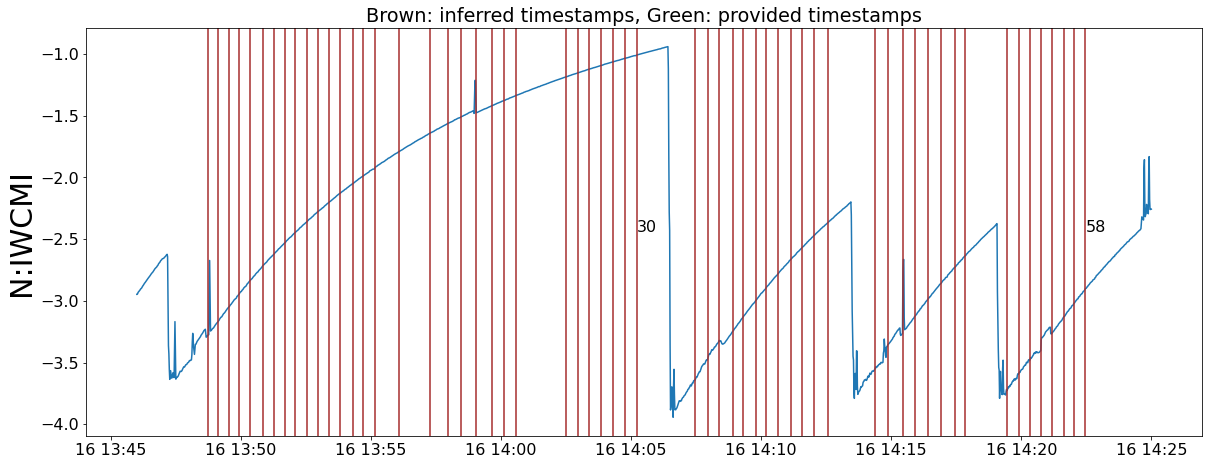

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:144: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)
/home/ilobach/fur/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [2]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [3]:
rdt = res_df_ROUND['real_datetime']
time_intervals = [(rdt[0], rdt[30]), (rdt[31], rdt[42]), (rdt[43], rdt[50]), (rdt[51], rdt[58])]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals

[(Timestamp('2020-03-16 13:48:45'), Timestamp('2020-03-16 14:05:13')),
 (Timestamp('2020-03-16 14:07:27'), Timestamp('2020-03-16 14:12:34')),
 (Timestamp('2020-03-16 14:14:23'), Timestamp('2020-03-16 14:17:51')),
 (Timestamp('2020-03-16 14:19:26'), Timestamp('2020-03-16 14:22:28'))]

### removing two outliers in ROUND data:

In [4]:
outliers_ROUND = ['RefCurve_2020-03-16_61_135841.Wfm.bin', 'RefCurve_2020-03-16_86_141506.Wfm.bin']
res_df_ROUND = res_df_ROUND[~res_df_ROUND['waveform_file'].isin(outliers_ROUND)]

In [5]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

In [6]:
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')

In [7]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [8]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [9]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [10]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

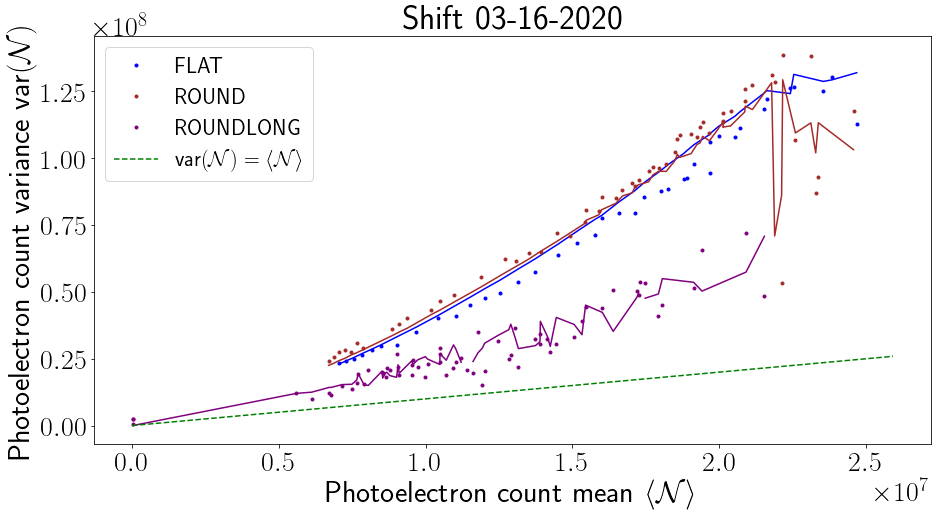

In [11]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

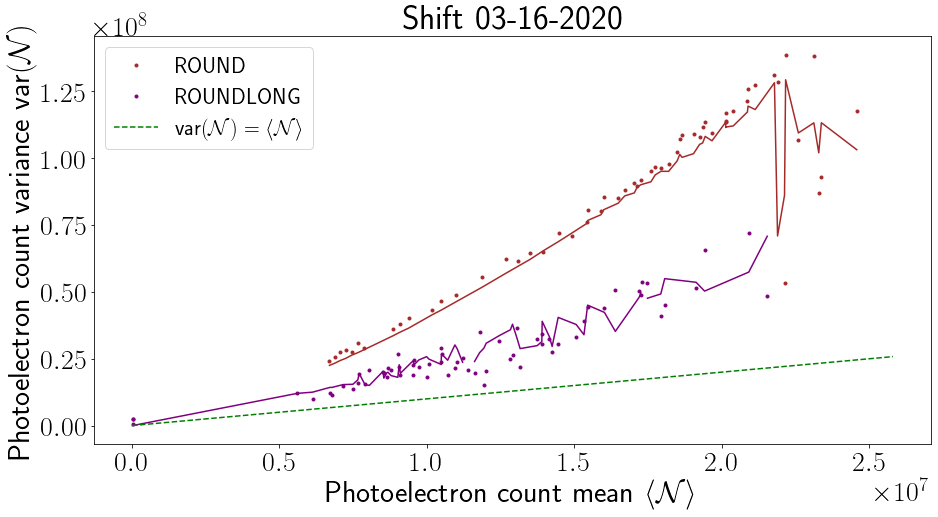

In [12]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [13]:
# acnet_df_ROUND_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_ROUND
# )

In [14]:
# acnet_df_ROUND_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'))

In [15]:
acnet_df_ROUND_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_ROUND_with_bunch_sizes_in_time_intervals = acnet_df_ROUND_with_bunch_sizes[acnet_df_ROUND_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

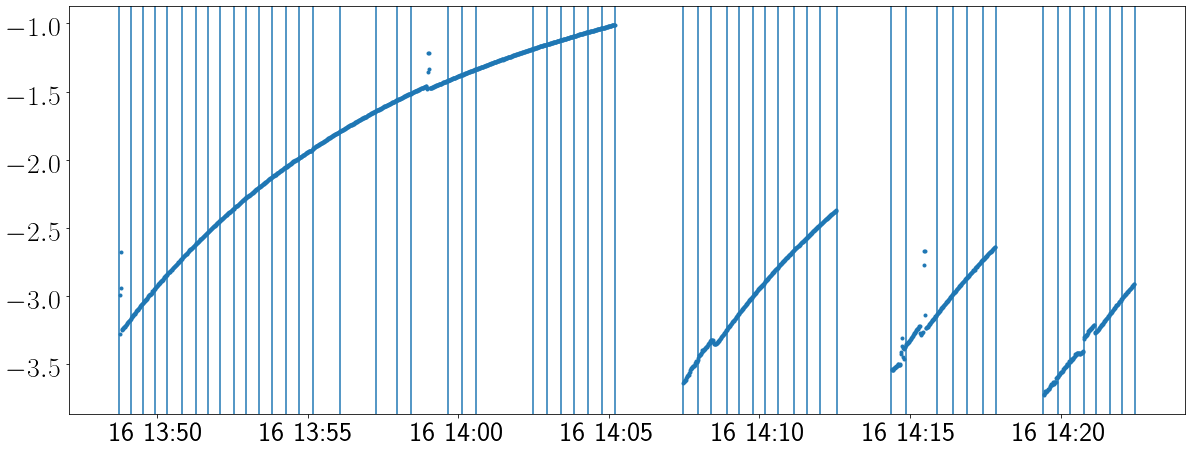

In [16]:
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

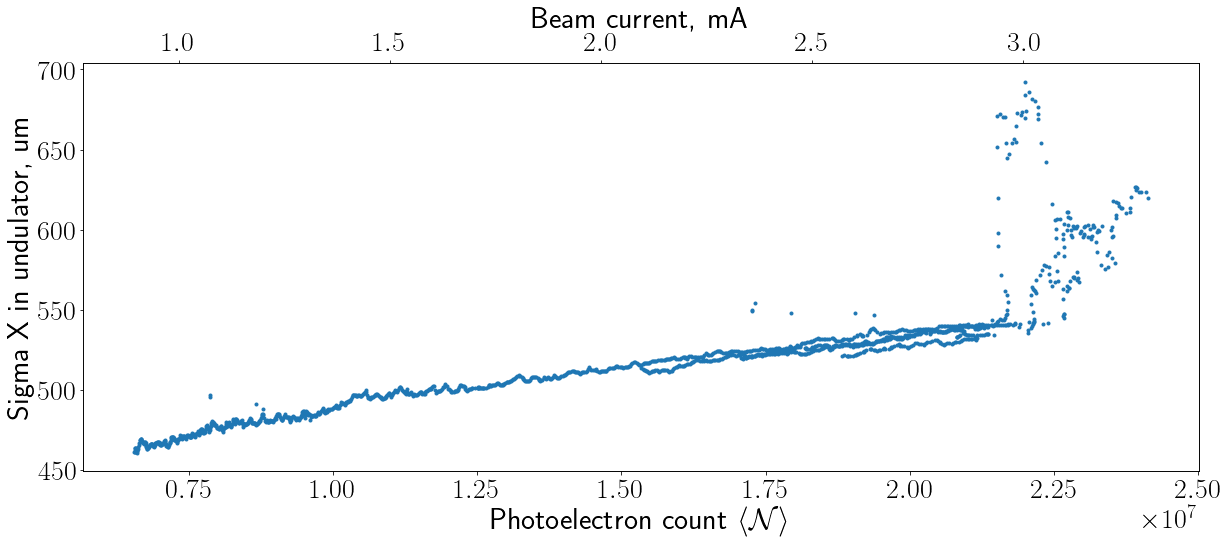

In [17]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

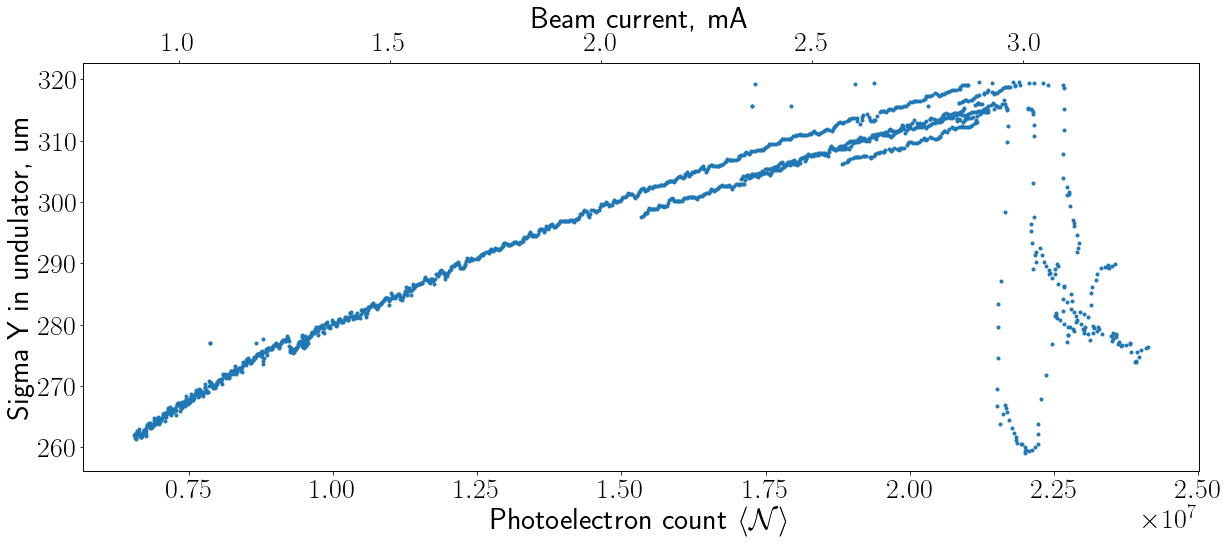

In [18]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

# Leaving only first injection:

In [19]:
first_injection = acnet_df_ROUND_with_bunch_sizes_in_time_intervals[acnet_df_ROUND_with_bunch_sizes_in_time_intervals.index<time_intervals[0][1]]
df = first_injection


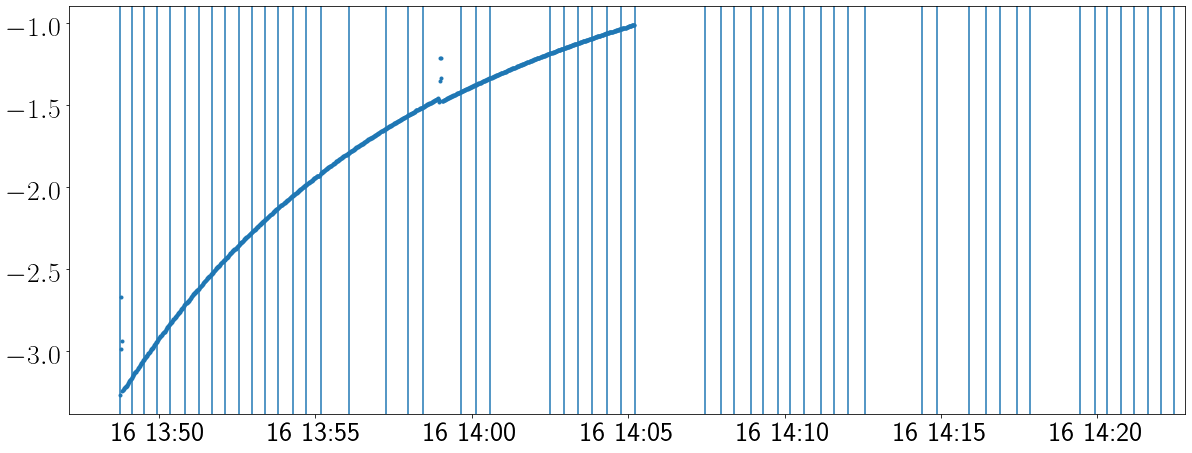

In [20]:
df = first_injection
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


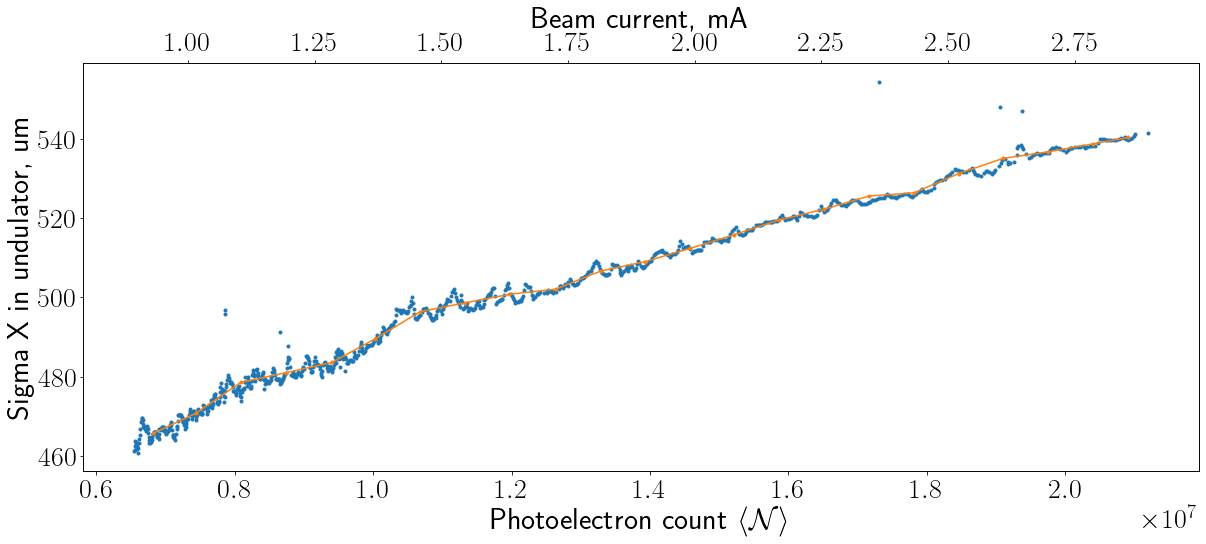

In [21]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_X'], bounds_error=False, fill_value="extrapolate")
sx_interp = sx_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.std(first_injection['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [22]:
sx_err_stat

2.02370910686093

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


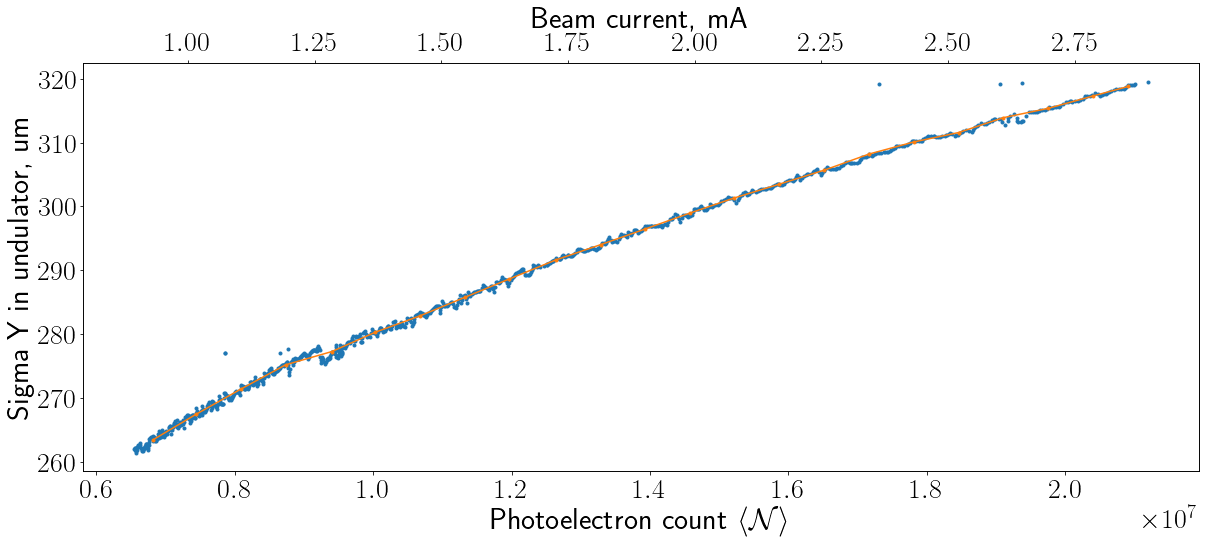

In [23]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_Y'], bounds_error=False, fill_value="extrapolate")
sy_interp = sy_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.std(first_injection['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [24]:
sy_err_stat

0.6831758341120098

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


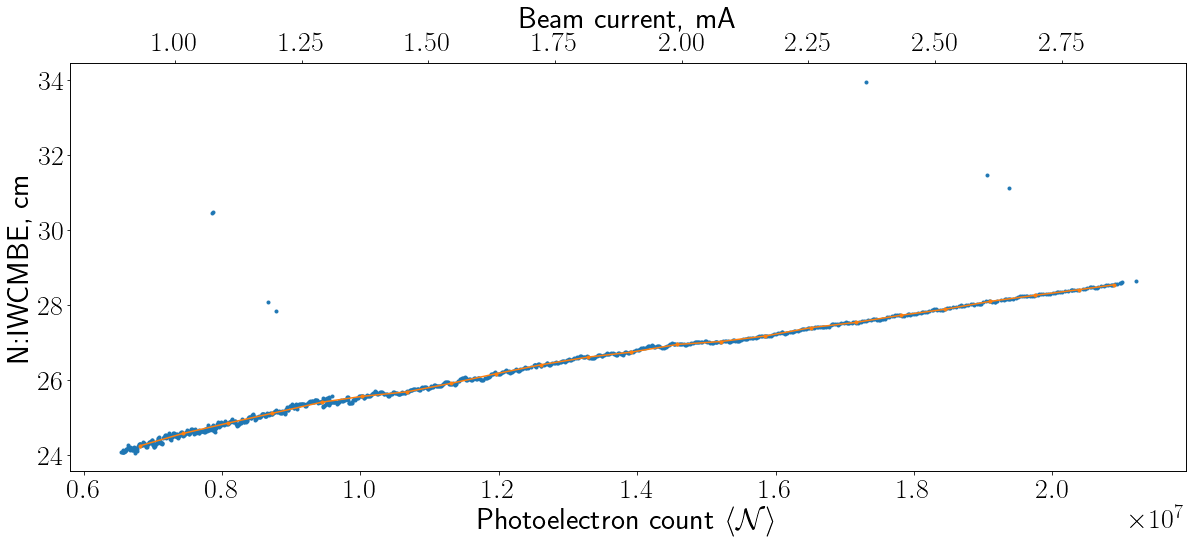

In [25]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBE'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBE'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [26]:
sz_err_stat

0.09119185892226393

In [27]:
df_desc = df.describe()
df_desc

,N:ITC1RSV,N:ITC1RSH,N:ITC2RSV,N:ITC2RSH,N:ITC3RSV,N:ITC3RSH,N:ITC4RSV,N:ITC4RSH,N:ITC4LSV,N:ITC4LSH,N:ITC3LSV,N:ITC3LSH,N:ITC2LSV,N:ITC2LSH,N:ITC1LSV,N:ITC1LSH,N:IWCMBF,N:IWCMBR,N:IWCMBP,N:IWCMI,N:IRFEPA,N:IRFEPP,N:IWCMBE,N:IWCMBM,N:IWCMBG,N:IWCMIG,N:IBEAMA,N:IRFEPC,N:IRFEAT,N:IRFEFP,N:IRFECG,N:IWCMI_recalibrated_to_IWCMI_absolute,N:IBEAM_recalibrated_to_IWCMI_absolute,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y,ex_um,ex_err,ey_um,ey_err,dp/p,dp/p_err
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0000,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0
mean,415.275929,185.224873,167.143762,553.030087,251.139119,721.221346,105.9989,7.327710e+02,496.268967,437.414139,248.090364,740.455566,167.003951,592.497538,505.412769,190.015560,60.912722,28.873069,-83.996575,-2.148166,358.327560,102.101766,26.620897,21.969983,25.804448,-2.114701,-1.963505,42.5,-8.800000e+00,8.462482,0.260194,-1.900191,-1.898193,507.872251,5.191876,294.715863,5.795252,0.000348,0.000398,0.096641,0.002589,0.088534,0.003463,0.000245,0.0
std,24.372849,9.829407,9.048052,22.654990,14.433556,31.705395,0.0000,1.162419e-13,24.153233,23.575204,16.018409,33.153919,9.316444,24.847986,31.452435,7.756713,2.752569,1.233297,0.149672,0.676078,0.466929,0.218996,1.278508,1.019517,1.224800,0.665322,0.603786,0.0,3.632560e-15,0.025488,0.000402,0.598035,0.583702,22.395409,0.147465,16.866593,0.264691,0.000016,0.000023,0.008563,0.000110,0.010030,0.000089,0.000010,0.0
min,370.324695,167.006473,150.576203,510.774735,224.500502,661.433255,105.9989,7.327710e+02,452.181100,393.224150,218.754433,678.629472,149.856373,546.254518,447.097222,175.549320,56.017198,26.576930,-84.239601,-3.225316,357.571776,101.740835,24.251174,20.083321,23.557682,-3.177511,-2.918038,42.5,-8.800000e+00,8.421928,0.259539,-2.853000,-2.820975,466.068979,5.013945,263.571130,5.526724,0.000319,0.000356,0.081093,0.002398,0.070589,0.003330,0.000226,0.0
25%,396.336833,177.733695,159.698953,539.075745,239.506925,700.515720,105.9989,7.327710e+02,478.503768,419.201995,235.135623,718.388017,159.533575,577.105010,480.622102,185.157075,58.609879,27.943459,-84.101010,-2.700020,357.945122,101.918404,25.625665,21.171294,24.777112,-2.656959,-2.453269,42.5,-8.800000e+00,8.440968,0.259819,-2.388342,-2.371666,492.722813,5.096208,281.606389,5.595626,0.000338,0.000380,0.090977,0.002521,0.080582,0.003384,0.000237,0.0
50%,417.972240,186.071505,168.257100,552.369020,252.990420,722.324490,105.9989,7.327710e+02,497.152540,439.950380,250.268345,741.412510,168.236100,592.346500,509.627010,190.030090,61.086304,29.000363,-83.985207,-2.148396,358.290331,102.108802,26.742871,22.069698,25.935686,-2.114936,-1.970830,42.5,-8.800000e+00,8.460000,0.260200,-1.900394,-1.905274,508.529129,5.161494,296.657078,5.626075,0.000349,0.000400,0.096582,0.002588,0.089424,0.003470,0.000246,0.0
75%,436.090859,193.248747,175.049672,570.201124,263.712036,745.778246,105.9989,7.327710e+02,516.173023,456.503490,262.037085,766.278245,175.078349,611.561744,532.550246,195.992351,63.051824,29.819013,-83.871964,-1.598080,358.704678,102.268693,27.631068,22.775768,26.773131,-1.571512,-1.483915,42.5,-8.800000e+00,8.480958,0.260510,-1.413604,-1.434556,525.263900,5.245367,309.116153,5.991281,0.000361,0.000417,0.103301,0.002674,0.097094,0.003524,0.000253,0.0
max,449.983995,199.270128,180.227030,586.267760,271.835150,766.397980,105.9989,7.327710e+02,531.658250,470.901365,271.095802,787.994488,180.324325,628.295990,549.988737,201.258427,65.346183,30.688231,-83.742617,-1.053108,359.029880,102.453990,28.536062,23.463036,27.712599,-1.038107,-0.974994,42.5,-8.800000e+00,8.510000,0.260900,-0.931542,-0.9

In [28]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


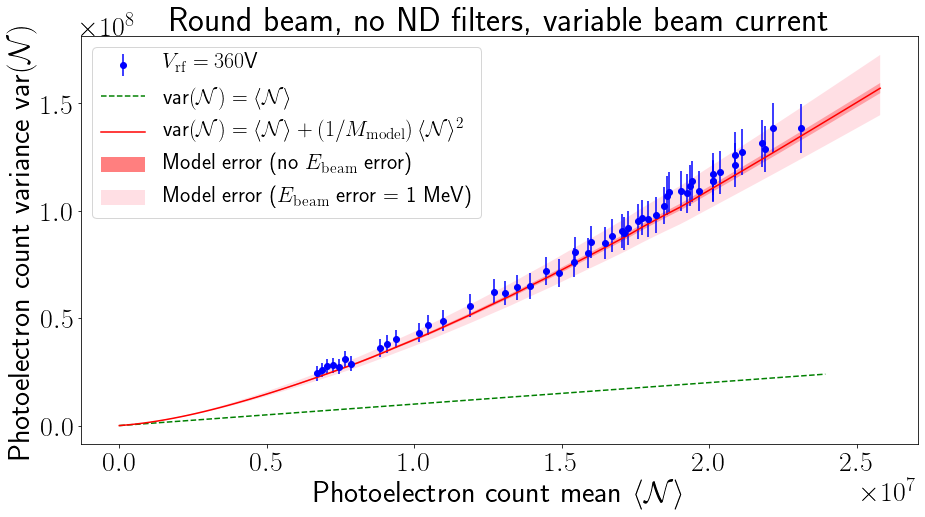

In [29]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'blue', "ROUNDLONG": 'purple'}
data_sets = {
    'ROUND': res_df_ROUND,#.iloc[0:30,:],
    'ROUNDLONG': res_df_ROUND_Low_RF}

theor_df = pd.DataFrame({"N": x_aux})
theor_df['sx'] = sx_func(theor_df['N'])
theor_df['sy'] = sy_func(theor_df['N'])
theor_df['sz'] = sz_func(theor_df['N'])
theor_df['sx_err_stat'] = sx_err_stat
theor_df['sy_err_stat'] = sy_err_stat
theor_df['sz_err_stat'] = sz_err_stat
theor_df['sx_err_sm'] = df_desc.loc['mean', 'Sigma_um_X_err']
theor_df['sy_err_sm'] = df_desc.loc['mean', 'Sigma_um_Y_err']
theor_df['sz_err_sm'] = 0
theor_df['sx_err_tot'] = np.sqrt(theor_df['sx_err_stat']**2+theor_df['sx_err_sm']**2)
theor_df['sy_err_tot'] = np.sqrt(theor_df['sy_err_stat']**2+theor_df['sy_err_sm']**2)
theor_df['sz_err_tot'] = np.sqrt(theor_df['sz_err_stat']**2+theor_df['sz_err_sm']**2)
theor_df['M'] = theor_df.apply(lambda row: Mfunc(*(row[['sx','sy','sz']])), axis=1)
theor_df['Mxder'] = theor_df.apply(lambda row: Mxder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Myder'] = theor_df.apply(lambda row: Myder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Mzder'] = theor_df.apply(lambda row: Mzder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Meder'] = theor_df.apply(lambda row: Meder(*(row[['sx','sy','sz']])), axis=1)
theor_df['M_err_no_Ebeam'] = np.sqrt(
    (theor_df['sx_err_tot']*theor_df['Mxder'])**2
    +(theor_df['sy_err_tot']*theor_df['Myder'])**2
    +(theor_df['sz_err_tot']*theor_df['Mzder'])**2)
Ebeam_error = get_from_config("Beam_energy_error_MeV")
theor_df['M_err_due_to_Ebeam'] = theor_df['Meder']*Ebeam_error
theor_df['M_err_with_Ebeam'] = np.sqrt(theor_df['M_err_due_to_Ebeam']**2
    + theor_df['M_err_no_Ebeam']**2)
theor_df['varN'] = var_theor(theor_df['N'], theor_df['M'])
theor_df['varN_top_no_Ebeam'] = var_theor(theor_df['N'], theor_df['M']-theor_df['M_err_no_Ebeam'])
theor_df['varN_bottom_no_Ebeam'] = var_theor(theor_df['N'], theor_df['M']+theor_df['M_err_no_Ebeam'])
theor_df['varN_top_with_Ebeam'] = var_theor(theor_df['N'], theor_df['M']-theor_df['M_err_with_Ebeam'])
theor_df['varN_bottom_with_Ebeam'] = var_theor(theor_df['N'], theor_df['M']+theor_df['M_err_with_Ebeam'])
fig, ax = plt.subplots(figsize=(15, 7.5))
theor_for_meas = np.interp(res_df_ROUND['N'], theor_df['N'], theor_df['varN'])
res_df_ROUND_no_outliers = res_df_ROUND[
    np.absolute(res_df_ROUND['varN']-theor_for_meas)<0.2e8
]
hybrid_errorbar = 2*hybrid_balance_error*np.absolute(res_df_ROUND_no_outliers['varN'])
error_bar = np.sqrt(hybrid_errorbar**2+fit_errorbar**2)
res_df_ROUND_no_outliers['errorbar'] = error_bar
ax.errorbar(res_df_ROUND_no_outliers['N'],res_df_ROUND_no_outliers['varN'],marker='o',linestyle='None',yerr=error_bar,color='b', label = r'$V_{\mathrm{rf}}=360$V')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(theor_df['N'], theor_df['varN'], color='red', label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{model}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom_no_Ebeam'],
    theor_df['varN_top_no_Ebeam'],
    facecolor='red', alpha=0.5, label='Model error (no $E_{\mathrm{beam}}$ error)')
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom_with_Ebeam'],
    theor_df['varN_top_with_Ebeam'],
    facecolor='pink', alpha=0.5, label='Model error ($E_{\mathrm{beam}}$ error = 1 MeV)')
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Round beam, no ND filters, variable beam current")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

In [30]:
res_df_ROUND_no_outliers.loc[:,['N', 'varN', 'errorbar']].to_csv(
    shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'))

In [31]:
theor_df.to_csv(shift.get_results_dir().fi('theor_ROUND_03_16_2020.csv'))